In [1]:
import datetime
import time
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import pandas as pd

from prometheus_pandas import query

In [2]:
mpl.rc("figure", figsize=(36,5))

PROMETHEUS = 'http://grafana.pi1.gve.vpn:9090/'

In [3]:
p = query.Prometheus(PROMETHEUS)

> This code creates a new `Prometheus` object from the `query` library, with the specified `PROMETHEUS` server address. 

> The Prometheus class provides an interface for querying a [Prometheus](https://prometheus.io) server and retrieving metric data. 

> This object `p` can be used to query the Prometheus server and retrieve the desired metric data.

In [4]:
def pick_host_df(p, instance, metrics, start, end):
    r = []
    for k, v in metrics.items():
        df = p.query_range(v % instance, start, end, 60)
        df.columns =[f"{instance}:{k}:{i}" for i in range(len(df.columns))]
        r.append(df)
    return r

> This code defines a function called `pick_host_df` that takes five arguments: `p`, `instance`, `metrics`, `start`, and `end`. The function iterates over the key-value pairs in `metrics` and uses the `query_range` method of `p` to query Prometheus with the formatted metric value (using `instance` as the format placeholder) over the specified time range. The resulting dataframe is then modified to have columns with a unique name based on the instance, metric key, and column index. The dataframes are added to a list `r` and returned at the end of the function.
- Note that `p` must be an instance of the `Prometheus` class with the `query_range` method, and `metrics` must be a dictionary with metric keys and values that can be formatted with `instance`.


In [5]:
def metrics():
    return {
        #"fs-mbytes-available": 'node_filesystem_avail_bytes{job="node",instance="%s"}/(1024 * 1024 * 1024)',
        #"mem-mbytes-available": 'node_memory_MemAvailable_bytes{job="node",instance="%s"}/(1024 * 1024 * 1024)',
        "net-conntrack": 'node_nf_conntrack_entries{job="node",instance="%s"}',
        #"net-traffic-packets": 'rate(node_network_receive_packets_total{instance="%s",job="node"}[1m])',
        #"node-load1m": 'node_load1{instance="%s",job="node"}',
        #"node-load5m": 'node_load5{instance="%s",job="node"}',
        "node-load15m": 'node_load15{instance="%s",job="node"}',
        "node-contextswitch": 'rate(node_context_switches_total{instance="%s",job="node"}[5m])',
        "cpu-idle": 'sum by (mode)(rate(node_cpu_seconds_total{mode="idle",instance="%s",job="node"}[1m])) * 100',
        "scheduled-run-secs": 'rate(node_schedstat_running_seconds_total{instance="%s",job="node"}[1m])',
        "scheduled-wait-secs": 'rate(node_schedstat_waiting_seconds_total{instance="%s",job="node"}[1m])',
        "net-trans-err": 'rate(node_network_transmit_errs_total{instance="%s",job="node",device="wg0"}[1m])',
        "net-recv-err": 'rate(node_network_receive_errs_total{instance="%s",job="node",device="wg0"}[1m])',
    }

> This code defines a function called `metrics` that returns a dictionary of metrics to be queried from Prometheus. Each metric is a string containing a Prometheus query with a `%s` placeholder for the instance to be queried. The metrics cover various aspects of system performance, such as CPU utilization, network traffic, and available memory.
- Note that some metrics are commented out and will not be included in the returned dictionary unless they are un-commented.

In [6]:
def combine_horizontal(*dfs):
    return pd.concat(list(*dfs), axis=1)

> This code defines a function called `combine_horizontal` that takes a variable number of dataframe arguments. The function uses the `concat` method of the `pandas` library to combine the dataframes into a single dataframe with columns from each input dataframe.

In [7]:
now = datetime.datetime.now()
past = now - datetime.timedelta(days=2, hours=6)

df = combine_horizontal(
    pick_host_df(p, "10.0.0.211:9100", metrics(), past, now)
)

> This code creates a new `datetime` instance called `now` using the current time. It then creates a new `datetime` instance called `past` by subtracting six hours from `now`. The `combine_horizontal` function is called with the result of the `pick_host_df` function, which queries Prometheus with the metrics from the `metrics` function for the instance `10.0.0.211:9100` over the time range from `past` to `now`. The result is assigned to a variable called `df`.

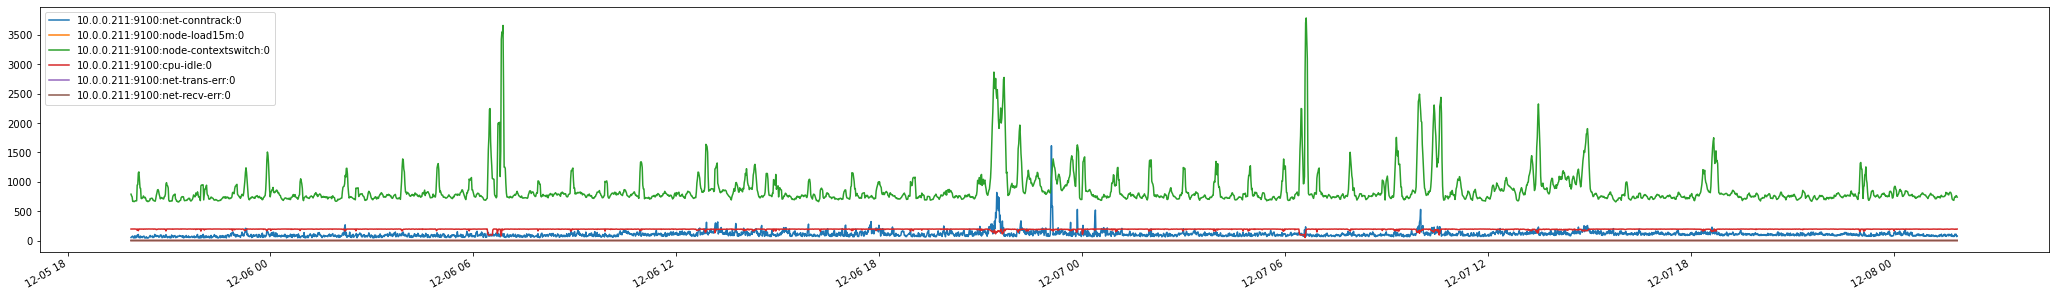

In [8]:
df.plot()
plt.legend(loc="upper left")

In [9]:
rollmean = df.resample('15T').mean()
rollstd = df.resample('15T').std()



> This code uses the `resample` method of the `df` dataframe to calculate the mean and standard deviation of the data over 15-minute intervals. The results are assigned to variables called `rollmean` and `rollstd`, respectively.

- This code is typically used in data analysis applications to calculate rolling statistics of a time series dataset. The resulting data can be used for further analysis or visualization.

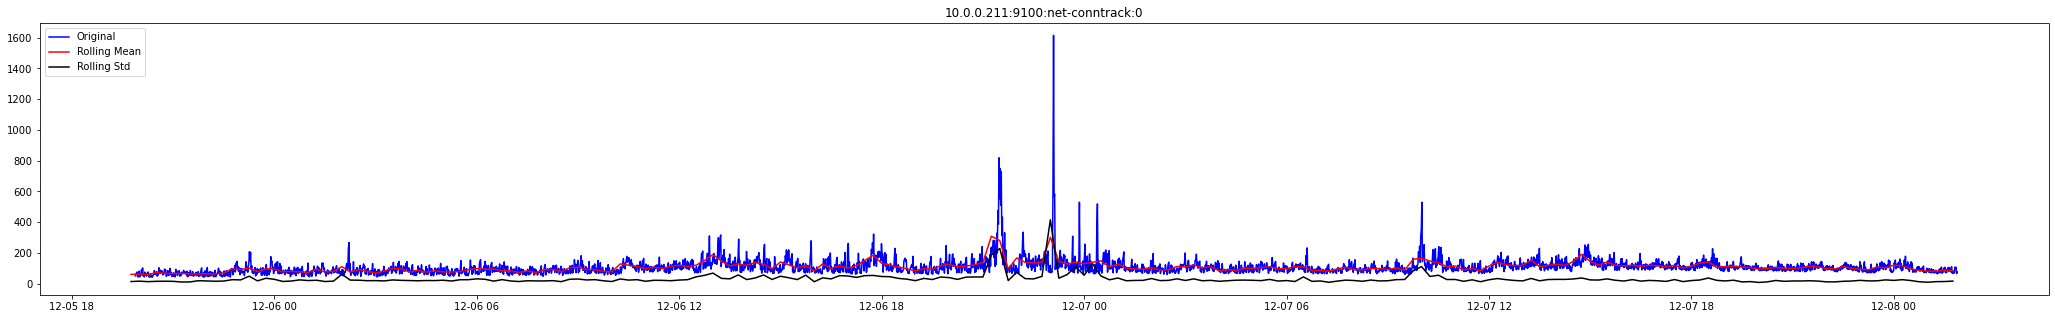

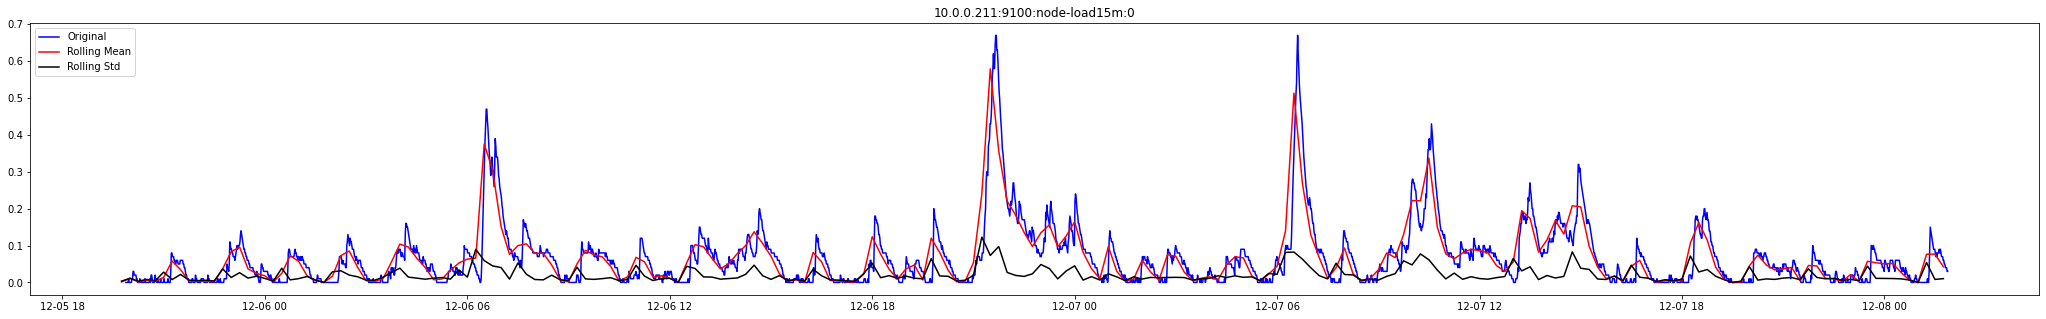

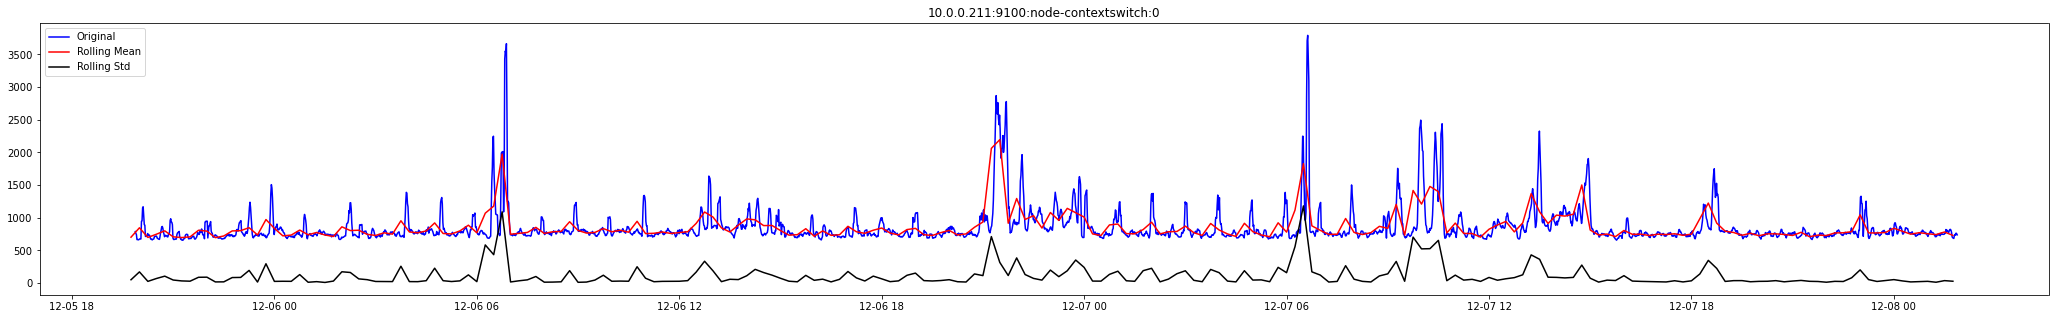

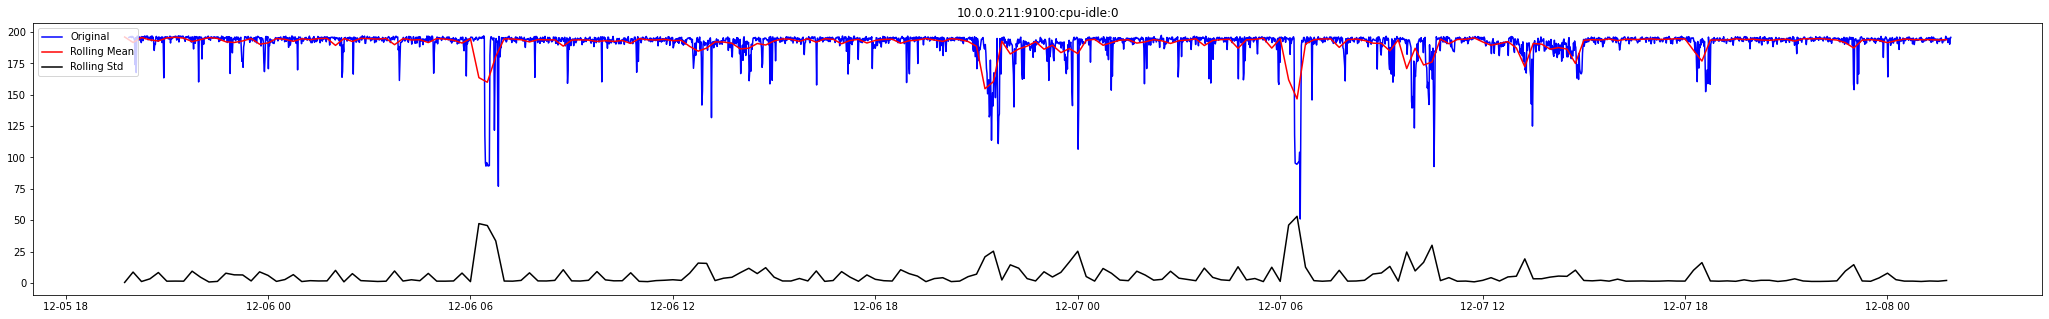

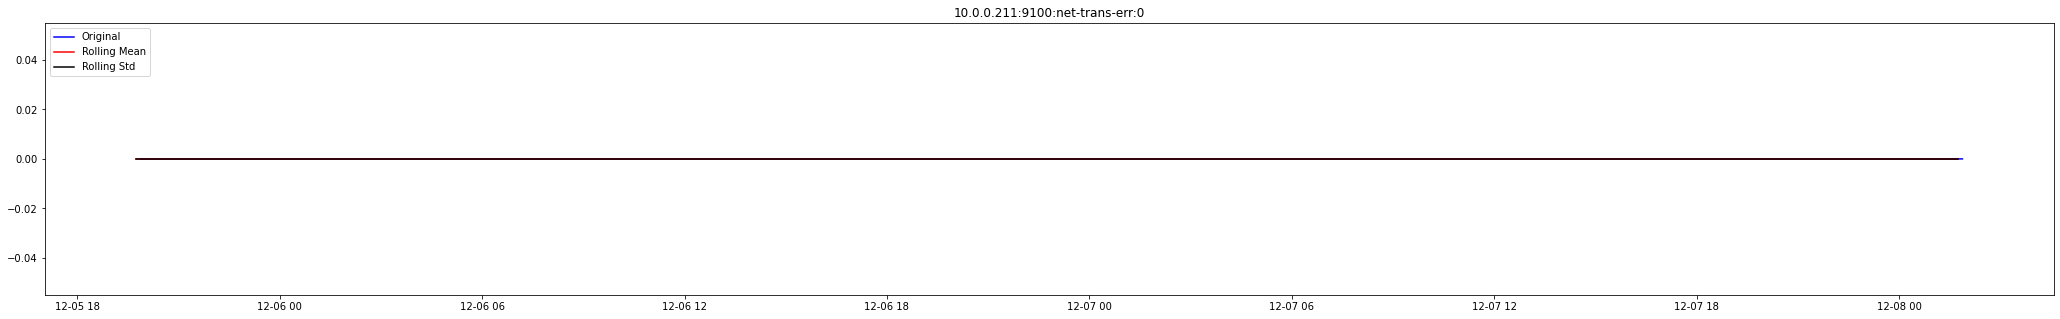

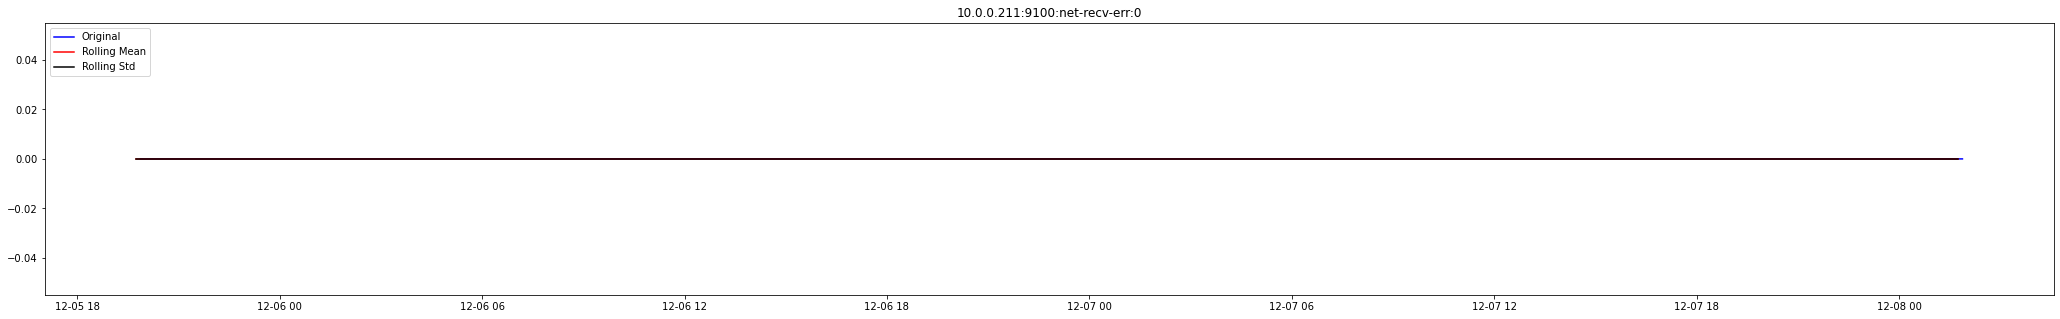

In [11]:
for name in df.columns:
    _ = plt.figure()
    _ = plt.plot(df[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='upper left')
    _ = plt.title(name)
    plt.show()

In [12]:
df.isnull().sum().sort_values(ascending=False)/len(df)

10.0.0.211:9100:net-conntrack:0         0.0
10.0.0.211:9100:node-load15m:0          0.0
10.0.0.211:9100:node-contextswitch:0    0.0
10.0.0.211:9100:cpu-idle:0              0.0
10.0.0.211:9100:net-trans-err:0         0.0
10.0.0.211:9100:net-recv-err:0          0.0
dtype: float64

> This code uses the `isnull` and `sum` methods of the `df` dataframe to calculate the fraction of missing values in each column. The result is sorted in descending order and returned.
- Note that the `df` dataframe must be a properly formatted dataframe for this code to work properly. The `pandas` library must be imported for this code to work properly.
- This code is typically used in data analysis applications to identify columns with a high number of missing values, which may require further cleaning or processing before being used for analysis or modeling.


In [13]:
df = df.fillna(df.mean())

> This code uses the `fillna` method of the `df` dataframe to replace missing values with the column-wise mean of the data. The resulting dataframe is assigned to `df`.
- Note that the `df` dataframe must be a properly formatted dataframe for this code to work properly. The `pandas` library must be imported for this code to work properly.
- This code is typically used in data analysis applications to impute missing values in a dataset, using the mean of the column as the replacement value. Other imputation methods, such as using the median or mode, may be more appropriate depending on the data and the analysis being performed.


In [14]:
# Standardize/scale the dataset and apply PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.values)

scaled_df = pd.DataFrame(
    scaled_features, 
    index=df.index, 
    columns=df.columns)

scaled_df.head()

,10.0.0.211:9100:net-conntrack:0,10.0.0.211:9100:node-load15m:0,10.0.0.211:9100:node-contextswitch:0,10.0.0.211:9100:cpu-idle:0,10.0.0.211:9100:net-trans-err:0,10.0.0.211:9100:net-recv-err:0
2022-12-05 19:52:36.355999947,-1.020694,-0.776868,-0.250345,0.401560,0.0,0.0
2022-12-05 19:53:36.355999947,-0.824996,-0.776868,-0.346878,0.431799,0.0,0.0
2022-12-05 19:54:36.355999947,-0.700460,-0.776868,-0.407675,0.433689,0.0,0.0
2022-12-05 19:55:36.355999947,-0.575925,-0.776868,-0.676184,0.431799,0.0,0.0
2022-12-05 19:56:36.355999947,-1.109648,-0.776868,-0.672017,0.473378,0.0,0.0


> This code uses the `StandardScaler` class from the `sklearn.preprocessing` module to scale the features in the `df` dataframe. The scaled features are then transformed into a new dataframe called `scaled_df`, with the same index and column names as the original dataframe.
- Note that the `sklearn` library and the `StandardScaler` class must be imported for this code to work properly. The `df` dataframe must be a properly formatted dataframe with numeric values for the scaling to be performed.
- This code is typically used in data analysis applications to standardize the scale of the features in a dataset. This can improve the performance of certain modeling techniques, such as distance-based algorithms, and can make it easier to compare and interpret the importance of different features in the data.


In [15]:
pca = PCA()
pca.fit(scaled_df)

for i, pc in enumerate(pca.explained_variance_ratio_):
    print("PC no.", i, "explains ", round(pc *100, 2), "% of data")



PC no. 0 explains  58.81 % of data
PC no. 1 explains  20.17 % of data
PC no. 2 explains  13.29 % of data
PC no. 3 explains  7.73 % of data
PC no. 4 explains  0.0 % of data
PC no. 5 explains  0.0 % of data


> This code uses the `PCA` class from the `sklearn.decomposition` module to perform principal component analysis on the `scaled_df` dataframe. The explained variance ratio of each principal component is then printed to the console.
- Note that the `sklearn` library and the `PCA` class must be imported for this code to work properly. The `scaled_df` dataframe must be a properly formatted dataframe with numeric values for the PCA to be performed.
- This code is typically used in data analysis applications to identify the most important dimensions in a dataset, as measured by the explained variance ratio of each principal component. This can be useful for reducing the dimensionality of the data and for visualizing the relationships between different features in the data.


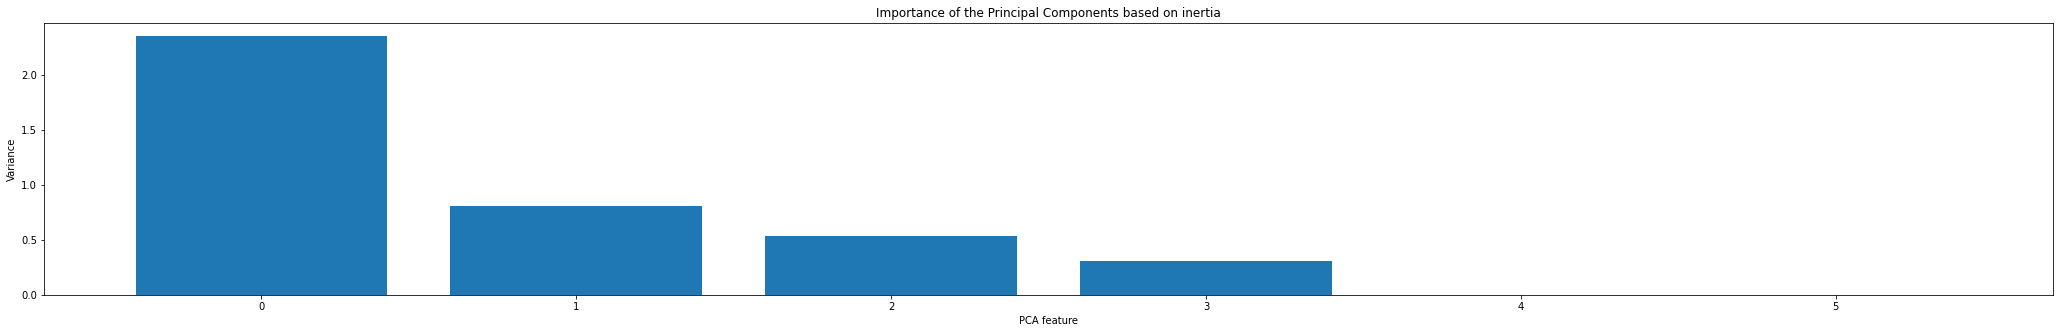

In [16]:
features = range(pca.n_components_)
_ = plt.figure()
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [17]:
n_components = 4

In [18]:
pca = PCA(n_components=n_components, random_state=0)

df_pca = pd.DataFrame(
    data=pca.fit_transform(scaled_df.values), 
    index=scaled_df.index
)
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)

> This code uses the `PCA` class from the `sklearn.decomposition` module to perform principal component analysis on the `scaled_df` dataframe. The number of principal components to be used is specified by the `n_components` parameter. The transformed data is then stored in a new dataframe called `df_pca`, and the original data is reconstructed using the inverse transform of the `df_pca` dataframe and stored in a new dataframe called `df_restored`.
- Note that the `sklearn` library and the `PCA` class must be imported for this code to work properly. The `scaled_df` dataframe must be a properly formatted dataframe with numeric values and a specified number of principal components (`n_components`).
- This code is typically used in data analysis applications to reduce the dimensionality of the data by projecting it onto a lower-dimensional subspace defined by the principal components. The reconstructed data in `df_restored` can be used for further analysis or comparison with the original data in `scaled_df`.
- The principal components are then stored in a Pandas dataframe `df_pca`, where the index is taken from the original scaled dataset. The code also restores the principal components to their original dimensions using the inverse_transform method of the `PCA` object, and stores the result in another Pandas dataframe `df_restored`. This allows us to compare the original and restored datasets to see how much information was lost due to the dimensionality reduction.

In [19]:
pca.explained_variance_ratio_

array([0.58811433, 0.20167391, 0.13291525, 0.07729651])

In [20]:
from statsmodels.tsa.stattools import adfuller

for pcN in range(n_components):
    result = adfuller(df_pca[pcN])
    # Print p-value
    print(result[1])

2.045756257220276e-09
4.613304957427547e-15
2.5505373758775946e-14
2.6247603575955847e-15


> The `adfuller` function from the `statsmodels.tsa.stattools` module is used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series dataset. The function returns a tuple of test statistics and p-values, which can be interpreted as follows:

- The `test statistic` is a measure of the strength of the evidence against the null hypothesis of non-stationarity. A low test statistic indicates stronger evidence of stationarity.
- The `p-value` is the probability of obtaining a test statistic at least as extreme as the observed value, under the assumption that the null hypothesis is true. A low p-value indicates stronger evidence against the null hypothesis and therefore stronger evidence of stationarity.

Therefore, in order to interpret the `adfuller` function, the test statistic and p-value should be considered together. A low p-value and low test statistic indicate strong evidence of stationarity, while a high p-value and high test statistic indicate strong evidence of non-stationarity.

- Note that the `statsmodels` library and the `adfuller` function must be imported for this code to work properly. The `adfuller` function must be applied to a properly formatted time series dataset.
- This code is typically used in [time series analysis](https://en.wikipedia.org/wiki/Time_series) applications in [data science](https://en.wikipedia.org/wiki/Data_science) to test the stationarity of a dataset. Stationarity is an important assumption for many time series modeling and forecasting techniques, and the `adfuller` function can provide insights into whether the dataset satisfies this assumption.
- Note that the `adfuller` function assumes that the data is stationary in the population, and therefore may not be appropriate for datasets with strong temporal dependencies or other complex structures. In addition, the function does not account for seasonality or other time-varying effects, and therefore may not be appropriate for datasets with these characteristics.


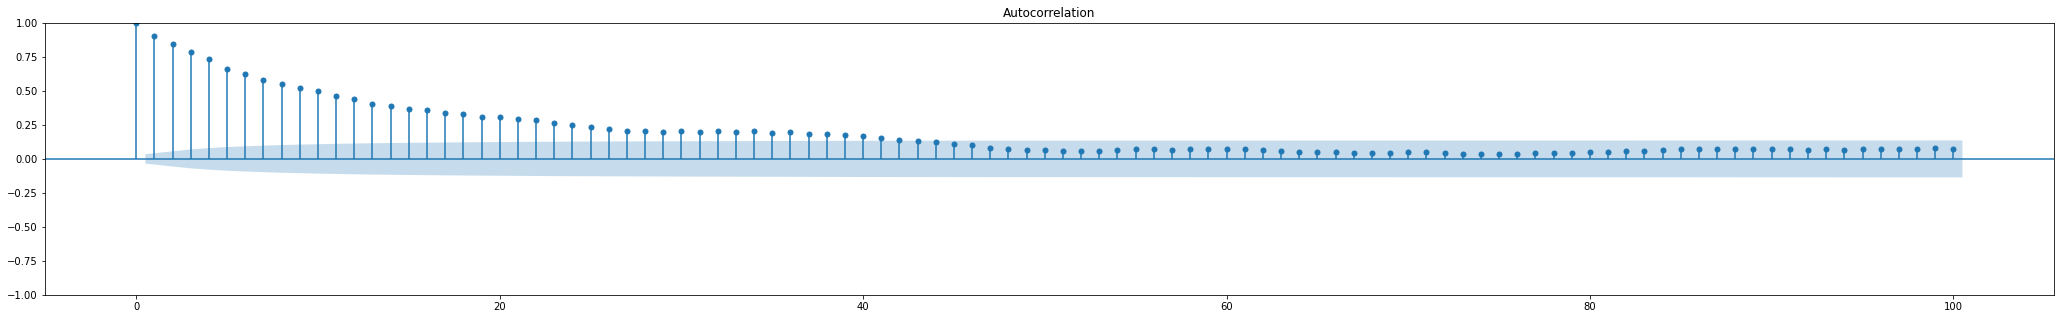

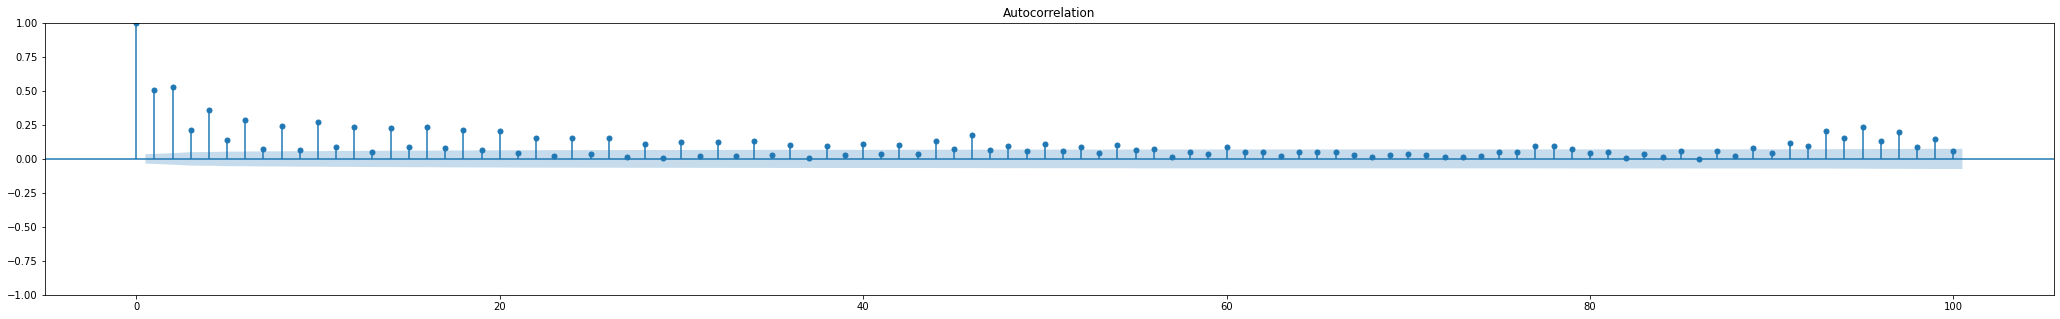

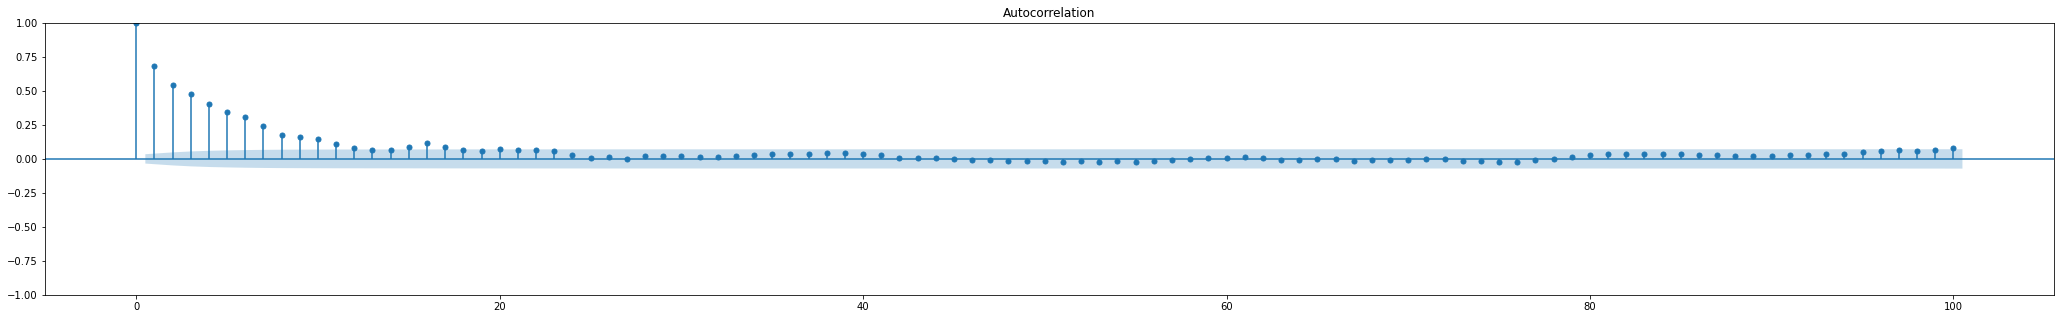

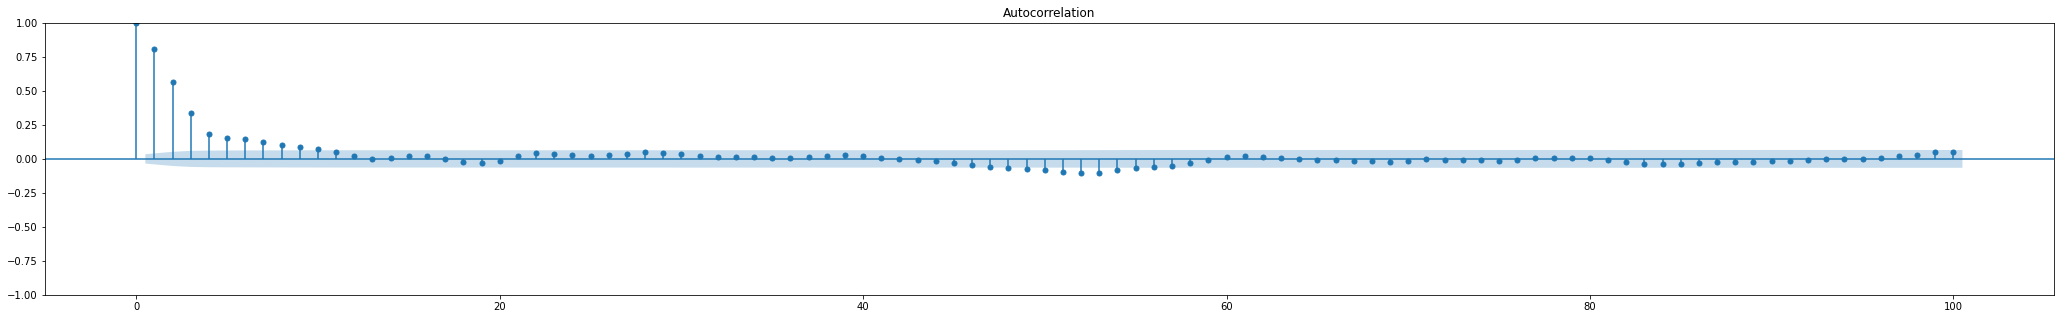

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

for i, _ in enumerate(pca.explained_variance_ratio_):
    _ = plot_acf(df_pca[i].dropna(), lags=100, alpha=0.05)

> The `plot_acf` function from the `statsmodels.graphics.tsaplots` module is used to plot the autocorrelation function (ACF) of a time series dataset. The ACF measures the linear correlation between a time series and its lagged values, and can provide insights into the temporal dependencies in the data. The `plot_acf` function takes the following parameters:

- `df_pca[i].dropna()`: the time series dataset to be plotted, with missing values removed.
- `lags=100`: the number of lags to be plotted in the ACF.
- `alpha=0.05`: the significance level for the confidence intervals of the ACF.

The resulting plot displays the ACF values on the y-axis and the lags on the x-axis. A strong positive correlation is indicated by large, positive ACF values, while a strong negative correlation is indicated by large, negative ACF values.

- Note that the `statsmodels` library and the `plot_acf` function must be imported for this code to work properly. The `df_pca[i].dropna()` input must be a properly formatted time series dataset with missing values removed.
- This code is typically used in time series analysis applications in data science to visualize the temporal dependencies in a dataset. The `plot_acf` function can help identify patterns and trends in the data that may be useful for modeling and forecasting.
- Note that the `plot_acf` function does not account for seasonality or other time-varying effects, and therefore may not be appropriate for datasets with these characteristics. In addition, the function assumes that the data is stationary in the population, and therefore may not be appropriate for datasets with strong temporal dependencies or other complex structures.


In [22]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

> This code defines a function called `get_anomaly_scores` that calculates the reconstruction error of the `df_original` dataframe using the restored data in `df_restored`. The error is defined as the sum of squared differences between the values in `df_original` and `df_restored` for each row. The resulting series of errors is returned.
- Note that the `numpy` library must be imported for this code to work properly. The `df_original` and `df_restored` dataframes must be properly formatted dataframes with matching indices and columns.
- This code is typically used in anomaly detection applications to calculate the reconstruction error of a time series dataset. High reconstruction errors can indicate unusual or anomalous data points, which may require further investigation or cleaning.


<AxesSubplot:>

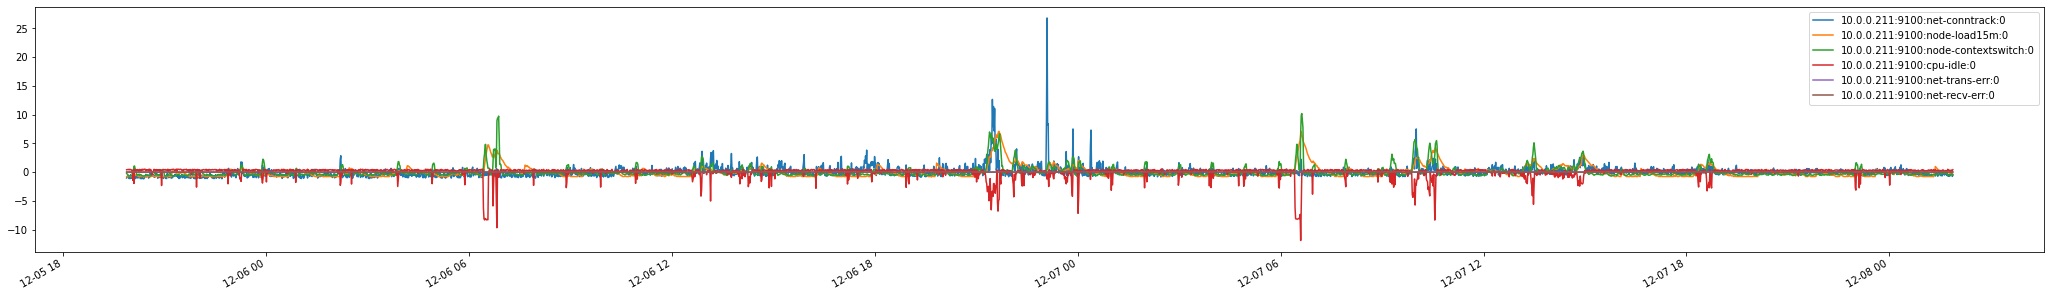

In [23]:
scaled_df.plot()

<AxesSubplot:>

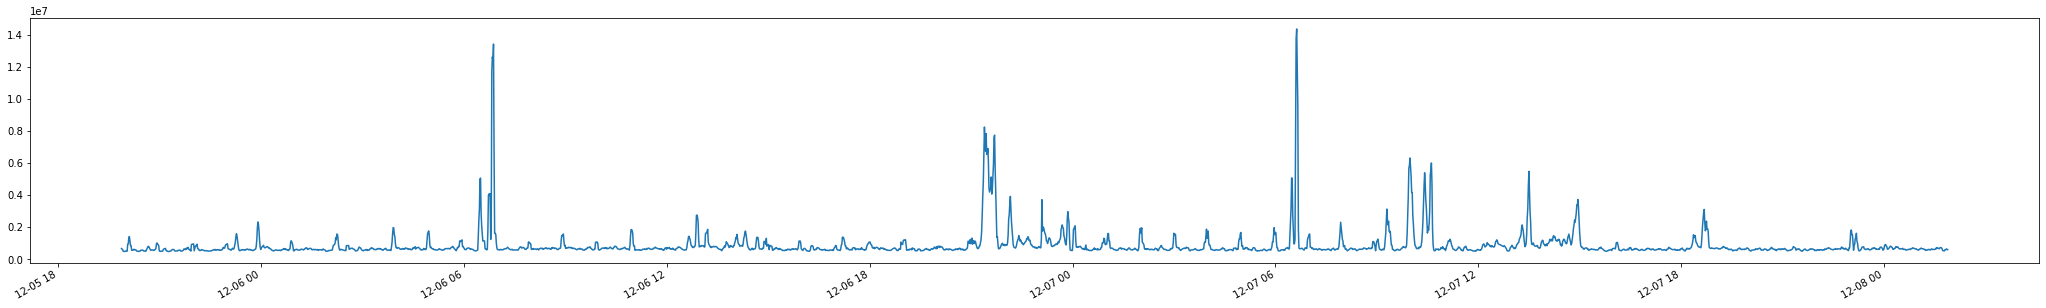

In [25]:
reconstruction_errors = get_anomaly_scores(df, df_restored)
reconstruction_errors.plot()

> This code uses the `get_anomaly_scores` function to calculate the reconstruction errors of the `df` dataframe using the restored data in `df_restored`. The resulting series of reconstruction errors is then plotted using the `plot` method of the `pandas` library.
- Note that the `get_anomaly_scores` function and the `pandas` library must be imported for this code to work properly. The `df` and `df_restored` dataframes must be properly formatted dataframes with matching indices and columns.
- This code is typically used in anomaly detection applications to visualize the reconstruction errors of a time series dataset. High reconstruction errors can indicate unusual or anomalous data points, which may require further investigation or cleaning.


In [26]:
def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    #print(loss, ">", threshold, loss > threshold)
    return loss > threshold

> This code defines a function called `is_anomaly` that performs anomaly detection on a single data point (`data`) using a fitted principal component analysis (PCA) model (`pca`) and a specified threshold for the reconstruction error (`threshold`). The function first transforms the `data` using the `pca` model and then applies the inverse transform to reconstruct the original data. The reconstruction error is calculated as the sum of squared differences between the `data` and the reconstructed data, and the function returns `True` if the error is greater than the specified `threshold` and `False` otherwise.
- Note that the `numpy` library must be imported for this code to work properly. The `data` and `pca` inputs must be properly formatted arrays or dataframes with numeric values, and the `pca` input must be a fitted PCA model.
- This code is typically used in anomaly detection applications to classify a single data point as anomalous or not based on its reconstruction error. The `is_anomaly` function can be applied to a series of data points to identify anomalous patterns in the data.


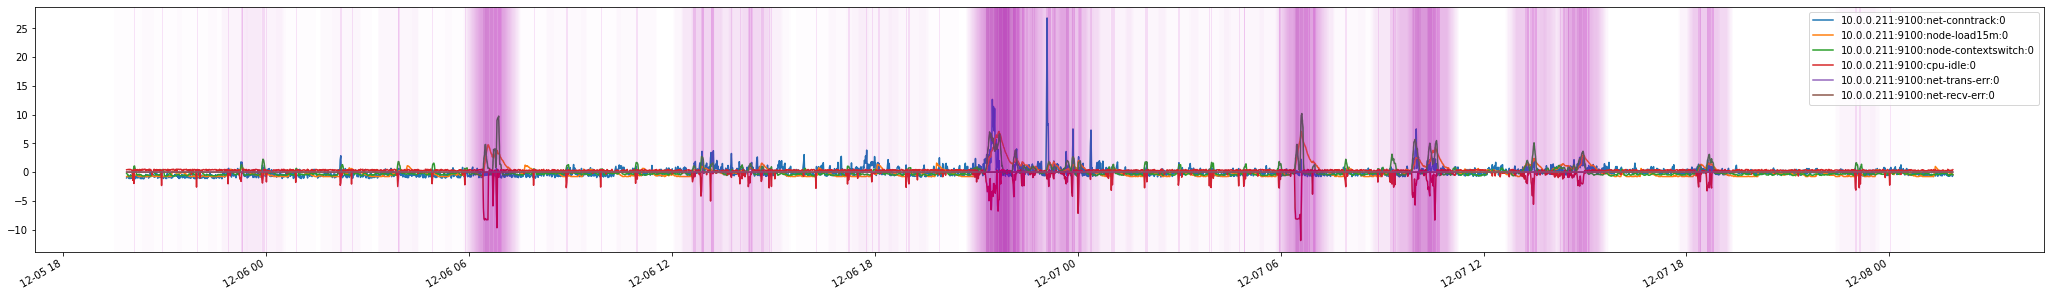

In [68]:
mpl.rc("figure", figsize=(36,5))
scaled_df.plot()
for index, row in scaled_df.iterrows():
    if is_anomaly([row.values], pca, 2.5 * 1e-30):
        plt.axvline(row.name, color='m', alpha=0.01, linewidth=40)
        plt.axvline(row.name, color='m', alpha=0.1, linewidth=1)

# Use the model to compute anomalous data in a new dataset

<AxesSubplot:>

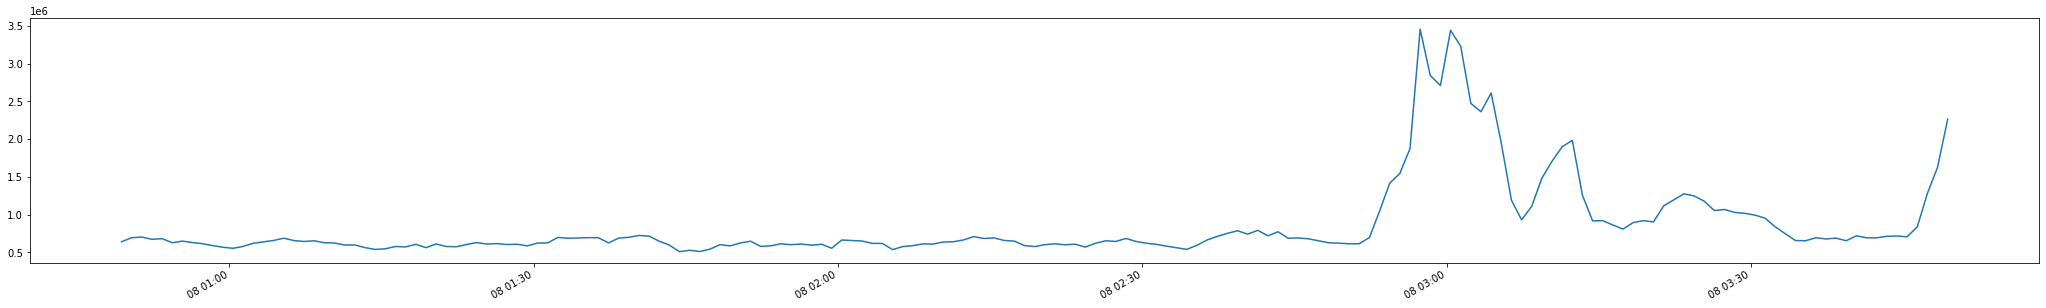

In [55]:
now_t = datetime.datetime.now()
past_t = now_t - datetime.timedelta(days=0, hours=3)

df_t = combine_horizontal(
    pick_host_df(p, "10.0.0.211:9100", metrics(), past_t, now_t)
)

scaled_features_t = scaler.fit_transform(df_t.values)

scaled_df_t = pd.DataFrame(
    scaled_features_t, 
    index=df_t.index, 
    columns=df_t.columns)

df_pca_t = pd.DataFrame(
    data=pca.fit_transform(scaled_df_t.values), 
    index=scaled_df_t.index
)
df_restored_t = pd.DataFrame(pca.inverse_transform(df_pca_t), index=df_pca_t.index)

reconstruction_errors_t = get_anomaly_scores(df_t, df_restored_t)
reconstruction_errors_t.plot()

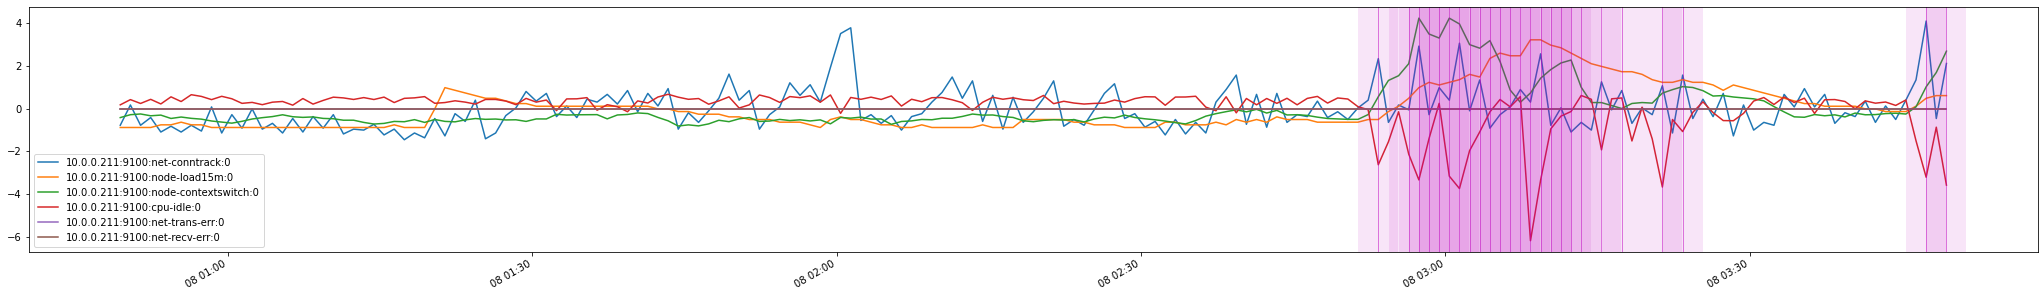

In [67]:
scaled_df_t.plot()
for index, row in scaled_df_t.iterrows():
    if is_anomaly([row.values], pca, 4 * 1e-30):
        plt.axvline(row.name, color='m', alpha=0.1, linewidth=40)
        plt.axvline(row.name, color='m', alpha=0.5, linewidth=1)